In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
!pip install os
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install opencv-python

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-

In [4]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
Class = os.listdir("/kaggle/input/yoga-poses-dataset/DATASET/TRAIN")
Class

['downdog', 'tree', 'plank', 'warrior2', 'goddess']

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dir = '/kaggle/input/yoga-poses-dataset/DATASET/TRAIN'
classlist=sorted(os.listdir(dir))
filepaths = []
labels=[]
for klass in classlist:
    classpath=os.path.join(dir, klass)
    flist=os.listdir(classpath)        
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
Fseries.head()


0    /kaggle/input/yoga-poses-dataset/DATASET/TRAIN...
1    /kaggle/input/yoga-poses-dataset/DATASET/TRAIN...
2    /kaggle/input/yoga-poses-dataset/DATASET/TRAIN...
3    /kaggle/input/yoga-poses-dataset/DATASET/TRAIN...
4    /kaggle/input/yoga-poses-dataset/DATASET/TRAIN...
Name: filepaths, dtype: object

In [7]:
IMAGE_SIZE = 224
CHANNELS = 3

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        rotation_range = 10
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/yoga-poses-dataset/DATASET/TRAIN',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 1081 images belonging to 5 classes.


In [8]:
test_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        rotation_range = 10
)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/yoga-poses-dataset/DATASET/TEST',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 470 images belonging to 5 classes.


In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

In [10]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
pre_trained_model = VGG16(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet"
)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()


2023-01-05 18:24:25.224135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 18:24:25.346387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 18:24:25.347242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 18:24:25.349010: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [11]:

model = tf.keras.models.Sequential([
    pre_trained_model,
    
    Flatten(),    
    Dense(256,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 21,139,781
Trainable params: 6,424,581
Non-trainable params: 14,715,200
____________________________________

In [12]:
model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics = ['acc']
)

In [13]:
!pip install pillow

In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
history = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=8
)

2023-01-05 18:24:41.625786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2023-01-05 18:24:44.442132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


34/34 [==============================] - 69s 2s/step - loss: 0.8471 - acc: 0.7206 - val_loss: 0.2167 - val_acc: 0.9234
Epoch 2/8
34/34 [==============================] - 45s 1s/step - loss: 0.3446 - acc: 0.9010 - val_loss: 0.1832 - val_acc: 0.9340
Epoch 3/8
34/34 [==============================] - 44s 1s/step - loss: 0.2244 - acc: 0.9325 - val_loss: 0.1471 - val_acc: 0.9511
Epoch 4/8
34/34 [==============================] - 44s 1s/step - loss: 0.1586 - acc: 0.9565 - val_loss: 0.1448 - val_acc: 0.9553
Epoch 5/8
34/34 [==============================] - 44s 1s/step - loss: 0.1165 - acc: 0.9722 - val_loss: 0.1179 - val_acc: 0.9617
Epoch 6/8
34/34 [==============================] - 44s 1s/step - loss: 0.0877 - acc: 0.9769 - val_loss: 0.1817 - val_acc: 0.9404
Epoch 7/8
34/34 [==============================] - 44s 1s/step - loss: 0.0872 - acc: 0.9796 - val_loss: 0.1629 - val_acc: 0.9574
Epoch 8/8
34/34 [==============================] - 44s 1s/step - loss: 0.0535 - acc: 0.9889 - val_loss: 0.1

**Training and Validation loss and Accuracy**

Text(0.5, 1.0, 'Training and validation loss')

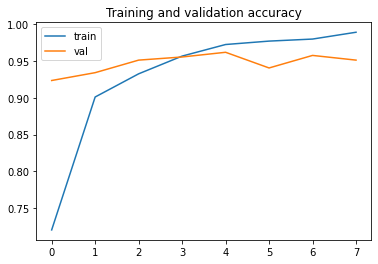

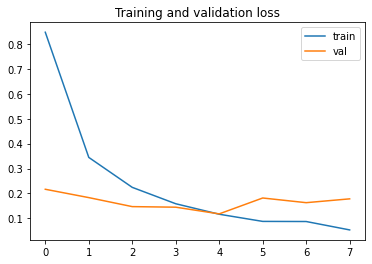

In [16]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))


# Plot training and validation accuracy per epoch
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train','val'])
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')

In [17]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_acc*100, test_acc*100))

15/15 [==============================] - 16s 1s/step - loss: 0.1602 - acc: 0.9511
final train accuracy = 99.63 , Test accuracy = 95.11
